In [1]:
from vina import Vina
from openbabel import openbabel as ob
from openbabel import pybel as pb
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
import time
import rdkit
import matplotlib.pyplot as plt
import random
import math
import re

In [ ]:
class SimulatedAnnealingOld:
    def __init__(self, fragments: list[str], vina: Vina):
        self.fragments = fragments
        self.vina:Vina = vina
        self.grid_box = None  #[0=> center, 1=>size]

    def setTarget(self, target_pdbqt_path: str, grid_param: tuple[int, list[int, int, int], list[int, int, int]] = None):
        '''
        grid_param = (spacing, center, box)
        '''
        self.vina.set_receptor(target_pdbqt_path)

        if grid_param is not None:
            self.setGridMap(grid_param)

    def setGridMap(self, grid_param: tuple[int, list[int, int, int], list[int, int, int]]):
        '''
        grid_param = (spacing, center, box)
        '''
        self.grid_box = [grid_param[1], grid_param[2]]
        if grid_param[0] == None:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2])
        else:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2], spacing=grid_param[0])

    def generateRdkitConformer(self, mol:rdkit.Chem.rdchem.Mol) -> rdkit.Chem.rdchem.Mol:
        '''input is rdkit mol and conformer is added to to same input mol and mol is also returned
        if it fails it will return None
        '''
        mol = AllChem.AddHs(mol)
        sucess = AllChem.EmbedMolecule(mol)

        if sucess == -1:
            return None

        return mol

    def placeRdkitMolAtNewPoint(self, mol: rdkit.Chem.rdchem.Mol, atom_idx: int, new_x: float, new_y: float, new_z: float) ->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule(conformer), conformer should be created for this method to work
        '''
        c = mol.GetConformer()
        atom_point = c.GetAtomPosition(atom_idx)
        x_offset = new_x - atom_point.x
        y_offset = new_y - atom_point.y
        z_offset = new_z - atom_point.z

        mol = self.shiftRdkitMol(mol, x_offset, y_offset, z_offset)

        return mol


    def shiftRdkitMol(self, mol: rdkit.Chem.rdchem.Mol, x_offset: float, y_offset: float, z_offset: float)->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule, offeset is, conformer should be created for this method to work
        '''

        c = mol.GetConformer()

        # shift all atoms
        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            pos.x += x_offset
            pos.y += y_offset
            pos.z += z_offset

            c.SetAtomPosition(i, pos)

        return mol

    def alignMolWithSubMol(self, mol, submol): # does not align hydrogen, mol as probe and submol as reference for alignment
        sc = submol.GetConformer()
        submol_index = [atom.GetIdx() for atom in submol.GetAtoms() if atom.GetAtomicNum()!=1]

        c = mol.GetConformer()
        mol_index = [atom.GetIdx() for atom in mol.GetAtoms() if atom.GetAtomicNum()!=1]

        atomMap = []
        for i in range(len(submol_index)):
            atomMap.append((mol_index[i], submol_index[i]))

        AllChem.AlignMol(mol, submol, atomMap=atomMap)

        return mol

    def getScore(self, ligand_pdbqt: str):
        '''return score of input ligand pose using vina
        '''
        self.vina.set_ligand_from_string(ligand_pdbqt)
        score = self.vina.score()

        return score[0]


    def rdkitToPdbqt(self, mol: rdkit.Chem.rdchem.Mol)->str:
        '''return pdbqt string of given rdkit mol
        '''
        mol_block = Chem.MolToMolBlock(mol) # sdf format

        pymol = pb.readstring(format="sdf", string=mol_block)
        pdbqt = pymol.write(format="pdbqt")

        return pdbqt

    def getRandomFragment(self) -> str:
        idx = random.randint(0, len(self.fragments)-1)
        self.idx = idx
        return self.fragments[idx]
        
    
    def isLigInGridbox(self,  mol: rdkit.Chem.rdchem.Mol):
        '''
        Returns true if all atoms of ligands(mol) are present inside the grid box
        '''
        c = mol.GetConformer()
        center = self.grid_box[0]
        size = self.grid_box[1]
        
        x_min = center[0] - size[0] / 2
        x_max = center[0] + size[0] / 2
        y_min = center[1] - size[1] / 2
        y_max = center[1] + size[1] / 2
        z_min = center[2] - size[2] / 2
        z_max = center[2] + size[2] / 2

        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            if (x_min <= pos.x <= x_max) and (y_min <= pos.y <= y_max) and (z_min <= pos.z <= z_max) is False:
                return False
        
        return True


    def simulatedAnnealingRecursive(self, 
                                    old_ligand: str,
                                    old_score: float, 
                                    old_ligand_3d, 
                                    initial_position: list, 
                                    max_mw: float, 
                                    temp: float, 
                                    iter: int, 
                                    coolingSchedule)-> dict:
        
        for i in range(100):
            frag = self.getRandomFragment()

            new_lig = old_ligand + frag

            try:
                mol = Chem.MolFromSmiles(new_lig)
                mol = self.generateRdkitConformer(mol)
            except:
                continue

            if mol is None:
                continue

            if old_ligand is None or old_ligand == '':
                # if current/new fragment is the first fragment then place this fragment at initial position
                mol = self.placeRdkitMolAtNewPoint(mol, 0, initial_position[0], initial_position[1], initial_position[2])
            else:
                # else align new/current mol to old molecule
                mol = self.alignMolWithSubMol(mol, old_ligand_3d)

            # checking if ligand is present inside grid box, if not then try other fragment
            if self.isLigInGridbox(mol) is False:
                continue

            # calculationg score of new/current ligand using vina
            pdbqt = self.rdkitToPdbqt(mol)
            
            new_score = self.getScore(pdbqt)
            del_score = new_score - old_score
            new_Temp = coolingSchedule(temp, iter)
            if del_score <= 0 or random.random() < math.exp(-del_score / new_Temp):
                
                if Descriptors.MolWt(mol) >= max_mw:
                    return (mol, new_lig, new_score)
                else:
                    result = self.simulatedAnnealingRecursive(old_ligand=new_lig, 
                                                              old_score=new_score, 
                                                              old_ligand_3d=mol, 
                                                              initial_position=initial_position, 
                                                              max_mw=max_mw, 
                                                              temp=temp, 
                                                              iter=iter+1,
                                                              coolingSchedule=coolingSchedule)
                    if result is not None:
                        return result
        return None




    def simulatedAnnealing(self, ligand:str='', 
                           start_score: float=0, 
                           ligand_3d=None, 
                           initial_building_position: list = [0, 0, 0], 
                           max_mw: float=100, 
                           temp: float=3000, 
                           iter = 0, 
                           coolingSchedule=None):
        return self.simulatedAnnealingRecursive(old_ligand=ligand, 
                                                old_score=start_score, 
                                                old_ligand_3d=ligand_3d, 
                                                initial_position=initial_building_position, 
                                                max_mw=max_mw, 
                                                temp=temp, 
                                                iter=iter, 
                                                coolingSchedule=coolingSchedule)



In [285]:
# adding fragments in between
class SimulatedAnnealing:
    def __init__(self, fragments: list[str], vina: Vina):
        self.fragments = fragments
        self.vina:Vina = vina
        self.grid_box = None  #[0=> center, 1=>size]

    def setTarget(self, target_pdbqt_path: str, grid_param: tuple[int, list[int, int, int], list[int, int, int]] = None):
        '''
        grid_param = (spacing, center, box)
        '''
        self.vina.set_receptor(target_pdbqt_path)

        if grid_param is not None:
            self.setGridMap(grid_param)

    def setGridMap(self, grid_param: tuple[int, list[int, int, int], list[int, int, int]]):
        '''
        grid_param = (spacing, center, box)
        '''
        self.grid_box = [grid_param[1], grid_param[2]]
        if grid_param[0] == None:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2])
        else:
            self.vina.compute_vina_maps(center=grid_param[1], box_size=grid_param[2], spacing=grid_param[0])

    def generateRdkitConformer(self, mol:rdkit.Chem.rdchem.Mol) -> rdkit.Chem.rdchem.Mol:
        '''input is rdkit mol and conformer is added to to same input mol and mol is also returned
        if it fails it will return None
        '''
        mol = AllChem.AddHs(mol)
        sucess = AllChem.EmbedMolecule(mol)

        if sucess == -1:
            return None

        return mol

    def placeRdkitMolAtNewPoint(self, mol: rdkit.Chem.rdchem.Mol, atom_idx: int, new_x: float, new_y: float, new_z: float) ->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule(conformer), conformer should be created for this method to work
        '''
        c = mol.GetConformer()
        atom_point = c.GetAtomPosition(atom_idx)
        x_offset = new_x - atom_point.x
        y_offset = new_y - atom_point.y
        z_offset = new_z - atom_point.z

        mol = self.shiftRdkitMol(mol, x_offset, y_offset, z_offset)

        return mol


    def shiftRdkitMol(self, mol: rdkit.Chem.rdchem.Mol, x_offset: float, y_offset: float, z_offset: float)->  rdkit.Chem.rdchem.Mol:
        ''' For shifing Rdkit molecule, offeset is, conformer should be created for this method to work
        '''

        c = mol.GetConformer()

        # shift all atoms
        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            pos.x += x_offset
            pos.y += y_offset
            pos.z += z_offset

            c.SetAtomPosition(i, pos)

        return mol

    def addFragmentRandomlyToLigandSmiles(self, lig_smile, frag_smile, chain_prob):
        '''Return new_smile and atom Map
        '''
        # total atoms in ligand smiles
        avaliable_idxs = [-1] # -1 so that at 0th place string can be added
        # for chain
        for i in range(len(lig_smile)): 
            if lig_smile[i].isalpha() == True: 
                avaliable_idxs.append(i)
        avaliable_idxs.append(len(lig_smile)) # for end 

        # probablities
        chain_prob = 0.1
        end_prob = 1-chain_prob
        avaliable_idx_probs = []
        for i in range(len(avaliable_idxs)):
            if i == 0 or i==len(avaliable_idxs)-1: avaliable_idx_probs.append(end_prob/2)
            else: avaliable_idx_probs.append(chain_prob/(len(avaliable_idxs)-2))

        # random position
        position = random.choices(
            population=avaliable_idxs,
            weights=avaliable_idx_probs,
            k=1
        )[0]

        new_lig_smile = ''
        insert_len = len(frag_smile)
        if position == avaliable_idxs[0]:
            new_lig_smile = frag_smile + lig_smile
        elif position == avaliable_idxs[-1]:
            new_lig_smile =  lig_smile + frag_smile
        else:
            insert_len += 2
            new_lig_smile = lig_smile[0:position+1] + '('+ frag_smile+')' + lig_smile[position+1:]


        # creating map
        lig_idx2atom = dict()
        atom_idx = 0
        for i in range(len(lig_smile)): 
            if lig_smile[i].isalpha() == True: 
                lig_idx2atom[i] = atom_idx
                atom_idx += 1

        new_lig_idx2atom = dict()
        atom_idx = 0
        for i in range(len(new_lig_smile)): 
            if new_lig_smile[i].isalpha() == True: 
                new_lig_idx2atom[i] = atom_idx
                atom_idx += 1

        atomMap = []
        for k, v in lig_idx2atom.items():
            if k<=position: atomMap.append((v, v))
            else: atomMap.append((new_lig_idx2atom[insert_len+k], v))
        

        return new_lig_smile, atomMap

    def getScore(self, ligand_pdbqt: str):
        '''return score of input ligand pose using vina
        '''
        self.vina.set_ligand_from_string(ligand_pdbqt)
        score = self.vina.score()

        return score[0]


    def rdkitToPdbqt(self, mol: rdkit.Chem.rdchem.Mol)->str:
        '''return pdbqt string of given rdkit mol
        '''
        mol_block = Chem.MolToMolBlock(mol) # sdf format

        pymol = pb.readstring(format="sdf", string=mol_block)
        pdbqt = pymol.write(format="pdbqt")

        return pdbqt

    def getRandomFragment(self) -> str:
        idx = random.randint(0, len(self.fragments)-1)
        self.idx = idx
        return self.fragments[idx]
        
    
    def isLigInGridbox(self,  mol: rdkit.Chem.rdchem.Mol):
        '''
        Returns true if all atoms of ligands(mol) are present inside the grid box
        '''
        c = mol.GetConformer()
        center = self.grid_box[0]
        size = self.grid_box[1]
        
        x_min = center[0] - size[0] / 2
        x_max = center[0] + size[0] / 2
        y_min = center[1] - size[1] / 2
        y_max = center[1] + size[1] / 2
        z_min = center[2] - size[2] / 2
        z_max = center[2] + size[2] / 2

        for i in range(c.GetNumAtoms()):
            pos = c.GetAtomPosition(i)
            if ((x_min <= pos.x <= x_max) and (y_min <= pos.y <= y_max) and (z_min <= pos.z <= z_max)) == False:
                return False
        
        return True


    def simulatedAnnealingRecursive(self, 
                                    old_ligand: str,
                                    old_score: float, 
                                    old_ligand_3d, 
                                    initial_position: list, 
                                    max_mw: float, 
                                    temp: float, 
                                    iter: int, 
                                    coolingSchedule,
                                    chain_prob:float)-> dict:
        
        for i in range(100):
            frag = self.getRandomFragment()

            new_lig, atomMap = self.addFragmentRandomlyToLigandSmiles(lig_smile=old_ligand, frag_smile=frag, chain_prob=chain_prob)

            try:
                mol = Chem.MolFromSmiles(new_lig)
                mol = self.generateRdkitConformer(mol)
            except:
                continue

            if mol is None:
                continue

            if old_ligand is None or old_ligand == '':
                # if current/new fragment is the first fragment then place this fragment at initial position
                mol = self.placeRdkitMolAtNewPoint(mol, 0, initial_position[0], initial_position[1], initial_position[2])
            else:
                # else align new/current mol to old molecule
                AllChem.AlignMol(mol, old_ligand_3d, atomMap=atomMap)

            # checking if ligand is present inside grid box, if not then try other fragment
            if self.isLigInGridbox(mol) is False:
                continue

            # calculationg score of new/current ligand using vina
            pdbqt = self.rdkitToPdbqt(mol)
            
            new_score = self.getScore(pdbqt)
            del_score = new_score - old_score
            new_Temp = coolingSchedule(temp, iter)
            if del_score <= 0 or random.random() < math.exp(-del_score / new_Temp):
                
                if Descriptors.MolWt(mol) >= max_mw:
                    return (mol, new_lig, new_score)
                else:
                    result = self.simulatedAnnealingRecursive(old_ligand=new_lig, 
                                                              old_score=new_score, 
                                                              old_ligand_3d=mol, 
                                                              initial_position=initial_position, 
                                                              max_mw=max_mw, 
                                                              temp=temp, 
                                                              iter=iter+1,
                                                              coolingSchedule=coolingSchedule,
                                                              chain_prob=chain_prob)
                    if result is not None:
                        return result
        return None




    def simulatedAnnealing(self, ligand:str='', 
                           start_score: float=0, 
                           ligand_3d=None, 
                           initial_building_position: list = [0, 0, 0], 
                           max_mw: float=100, 
                           temp: float=3000, 
                           iter = 0, 
                           coolingSchedule=None,
                           chain_prob:float = 0):
        return self.simulatedAnnealingRecursive(old_ligand=ligand, 
                                                old_score=start_score, 
                                                old_ligand_3d=ligand_3d, 
                                                initial_position=initial_building_position, 
                                                max_mw=max_mw, 
                                                temp=temp, 
                                                iter=iter, 
                                                coolingSchedule=coolingSchedule,
                                                chain_prob=chain_prob)



In [3]:
def coolingSchedule(temp, iter):
    return temp * 0.5 ** iter


In [4]:
f_file = open("frags.smi")
frags = f_file.read().split("\n")
frags = [re.sub(r'\s+', '', frag) for frag in frags if '.' not in frag]

In [286]:
vina = Vina()

s = SimulatedAnnealing(fragments=frags, vina=vina)
s.setTarget(target_pdbqt_path='new_tar.pdbqt', grid_param=(None, [20, -50, 10], [40, 40, 40]))

Computing Vina grid ... done.


In [293]:
result = s.simulatedAnnealing(ligand='', 
                              start_score=0, 
                              ligand_3d=None, 
                              initial_building_position=[16, -40, 8], 
                              max_mw=500, 
                              temp=300, 
                              coolingSchedule=coolingSchedule,
                              chain_prob=0.5)

[16:40:28] Explicit valence for atom # 16 O, 3, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 27 28 29 30
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 23 24 25
[16:40:28] SMILES Parse Error: ring closure 1 duplicates bond between atom 16 and atom 17 for input: 'c1(sc(nn1)N)c1c(OC(C(C1(C(=C(C(=CC1c1ccc(cc1)F)c1ccccc1)C#N)N)(C#N)C#N))C)cccc1'
[16:40:28] Explicit valence for atom # 4 N, 6, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 25 26 27
[16:40:28] Explicit valence for atom # 16 C, 5, is greater than permitted
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 6 7 11 12 13 14 15 21 22 23 25 37 38 39 40
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 28 29 33 34 35 36
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 18 19 20
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 21
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
[16:40:28] Can't kekulize mol.  Unkekulized atoms: 3

In [294]:
result

(<rdkit.Chem.rdchem.Mol at 0x7efc26e4ee40>,
 'c1(c(n(c2c1cccc2)CCOC)C)C(=O)ON1c2c(C3C(C1C(=O)O)CC=C3)cc(cc2Cl)Cl',
 25.164)

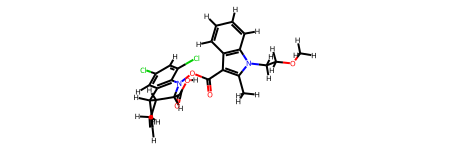

In [295]:
result[0]

In [188]:
sm2 = "C(C)C(C)"
sm1 = "OOO"

In [189]:
lig_smile= sm2
frag_smile = sm1

In [282]:
def addFragmentRandomlyToLigandSmiles(lig_smile, frag_smile, chain_prob):
    '''Return new_smile and atom Map
    '''
    # total atoms in ligand smiles
    avaliable_idxs = [-1] # -1 so that at 0th place string can be added
    # for chain
    for i in range(len(lig_smile)): 
        if lig_smile[i].isalpha() == True: 
            avaliable_idxs.append(i)
    avaliable_idxs.append(len(lig_smile)) # for end 

    # probablities
    chain_prob = 0.1
    end_prob = 1-chain_prob
    avaliable_idx_probs = []
    for i in range(len(avaliable_idxs)):
        if i == 0 or i==len(avaliable_idxs)-1: avaliable_idx_probs.append(end_prob/2)
        else: avaliable_idx_probs.append(chain_prob/(len(avaliable_idxs)-2))

    # random position
    position = random.choices(
        population=avaliable_idxs,
        weights=avaliable_idx_probs,
        k=1
    )[0]

    new_lig_smile = ''
    insert_len = len(frag_smile)
    if position == avaliable_idxs[0]:
        new_lig_smile = frag_smile + lig_smile
    elif position == avaliable_idxs[-1]:
        new_lig_smile =  lig_smile + frag_smile
    else:
        insert_len += 2
        new_lig_smile = lig_smile[0:position+1] + '('+ frag_smile+')' + lig_smile[position+1:]


    # creating map
    lig_idx2atom = dict()
    atom_idx = 0
    for i in range(len(lig_smile)): 
        if lig_smile[i].isalpha() == True: 
            lig_idx2atom[i] = atom_idx
            atom_idx += 1

    new_lig_idx2atom = dict()
    atom_idx = 0
    for i in range(len(new_lig_smile)): 
        if new_lig_smile[i].isalpha() == True: 
            new_lig_idx2atom[i] = atom_idx
            atom_idx += 1

    atomMap = []
    for k, v in lig_idx2atom.items():
        if k<=position: atomMap.append((v, v))
        else: atomMap.append((new_lig_idx2atom[insert_len+k], v))
    

    return new_lig_smile, atomMap

In [284]:
addFragmentRandomlyToLigandSmiles('C', 'CC', 0.5)

('CCC', [(2, 0)])

In [280]:
print(atomMap)
print(new_lig_smile)

[(3, 0), (4, 1), (5, 2), (6, 3)]
OOOC(C)C(C)


In [265]:
print(new_lig_idx2atom)
print(lig_idx2atom)
print(new_lig_smile)

{0: 0, 2: 1, 4: 2, 5: 3, 6: 4, 9: 5, 11: 6}
{0: 0, 2: 1, 4: 2, 6: 3}
C(C(OOO))C(C)


In [244]:
print(position)
print(new_lig_smile)

-1
OOOC(C)C(C)


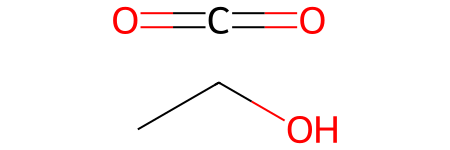

In [246]:
smiles1 = 'CCO'  # Example molecule 1: Ethanol
smiles2 = 'O=C=O'  # Example molecule 2: Carbon dioxide

# Create RDKit molecule objects from the SMILES strings
mol1 = Chem.MolFromSmiles(smiles1)
mol2 = Chem.MolFromSmiles(smiles2)

# Combine the two molecules into a single molecule
combined_mol = Chem.CombineMols(mol1, mol2)
combined_mol

In [209]:
m1 = Chem.MolFromSmiles("C(O)C(O)C(C)")
[(atom.GetIdx(), atom.GetAtomicNum()) for atom in m1.GetAtoms()]

[(0, 6), (1, 8), (2, 6), (3, 8), (4, 6), (5, 6)]

In [210]:
print(position)
print(new_lig_smile)

SyntaxError: invalid syntax (2871620560.py, line 2)

In [198]:
avaliable_idx_probs

[0.45, 0.025, 0.025, 0.025, 0.025, 0.45]

In [91]:
a = "dd"
b = a
b = b+'r'
a

'dd'

In [87]:
avaliable_idx_probs

[0.25, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.25]

In [88]:
avaliable_idxs

[-1, 0, 1, 2, 4]

In [84]:
total_atoms

9

In [82]:
''.isalpha()

False

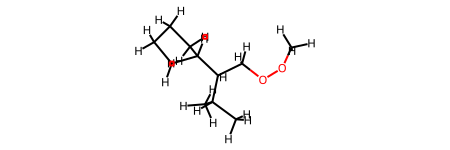

In [76]:
m3 = Chem.MolFromSmiles("C1CCCC1C(COOC)C(C)(C)")
m3 = AllChem.AddHs(m3)
sucess = AllChem.EmbedMolecule(m3)
m3

In [68]:
a = m2.GetAtomWithIdx(3)


In [69]:
a.GetAtomicNum()

6

In [70]:
c = m2.GetConformer()
atoms = m2.GetAtomWithIdx
for i in range(c.GetNumAtoms()):
    pos = c.GetAtomPosition(i)
    print(pos.x, pos.y, pos.z, m2.GetAtomWithIdx(i).GetAtomicNum())

1.1506860549298685 0.7007709055710742 0.6038579454174144 6
2.671561894789035 0.5710908165379416 0.38934213779486676 6
2.8881113333319695 -0.7895211566861843 -0.19945841780626197 6
1.5205311347781933 -1.4460729540782757 -0.21551350645983608 6
0.6245466667371755 -0.2181836119986849 -0.4422927516155217 6
-0.7933784810924638 -0.6369006667097407 -0.31252473407295656 6
-1.8278239838704928 0.41963344609341324 -0.342688609452989 6
-1.7749741014189406 1.4687647083163307 0.7047072641269793 6
-3.179996662718203 -0.30111679448638884 -0.18160784891629328 6
0.933410294470462 1.7580833119836812 0.48880577333774816 1
0.9326489912638745 0.25999595264309017 1.596966375224916 1
3.148444695266622 0.6215245159322546 1.3901929366472745 1
3.026308079967616 1.3909077784891646 -0.26474799007600264 1
3.2369777778768736 -0.7357949331437094 -1.2677949376956994 1
3.629765010789062 -1.3896780003933267 0.3703991553344848 1
1.269510294142485 -1.8038862065662855 0.8023600981059081 1
1.40596798565907 -2.188743257434048

In [73]:
c = m3.GetConformer()
atoms = m3.GetAtomWithIdx
for i in range(c.GetNumAtoms()):
    pos = c.GetAtomPosition(i)
    pos.x += 20
    pos.y += 20
    pos.z += 20

    c.SetAtomPosition(i, pos)
    print(pos.x, pos.y, pos.z, m3.GetAtomWithIdx(i).GetAtomicNum())

21.407120853409737 22.077154387455003 20.0957800004924 6
22.614393207818836 22.652203786277855 20.79257296516815 6
23.509022302448315 21.50171408310428 21.14765905986584 6
22.87616908583483 20.30676707589393 20.401351040941165 6
21.395294005177323 20.59199879931908 20.412847503571133 6
20.666564061276485 19.798410285302367 19.386148603330188 6
19.22173056843407 20.222262475419953 19.220044807788504 6
18.403662452006152 20.091200953104945 20.4753293342299 6
16.992821006461842 20.57079551328307 20.106992690067624 6
16.1694033605043 20.438422577190064 21.372895037442454 6
16.360581954957922 19.636282321881474 19.08489984860032 6
20.610771157962816 18.324194023337718 19.60320732313953 6
19.82143233788491 17.643734193282246 18.475022664441752 6
21.89197975435199 17.59759034274864 19.748938725606358 6
21.520723875670512 22.278228629832356 19.02178566636841 1
20.506753253416445 22.586927056650467 20.502526426632826 1
22.342795555075472 23.26595743700678 21.671233611120883 1
23.207814908924842

In [74]:
AllChem.AlignMol(m3, m2, )

RuntimeError: No sub-structure match found between the probe and query mol

In [65]:
c: rdkit.Chem.rdchem.Conformer
for x in c.GetPropNames(): print(x)

In [49]:
result

(<rdkit.Chem.rdchem.Mol at 0x7efc27288a50>,
 'c1(N2CCCC2)cc(C(=O)O)ccc1CC(c1ncccc1)(c1ccccc1)NCCCOCCC(=O)NC(c1ccc(cc1)OCC)C',
 80.417)

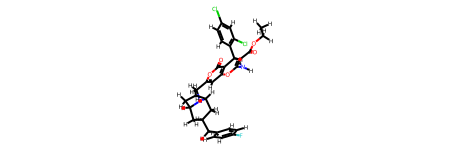

In [136]:
result[0]

In [112]:
Descriptors.HeavyAtomMolWt(result[0])

520.3830000000004

In [ ]:
pdb = s.rdkitToPdbqt(result[0])

f = open('simple.pdbqt', 'w')
f.write(pdb)
f.close()

In [137]:
vina.set_ligand_from_string(s.rdkitToPdbqt(result[0]))
# vina.optimize()

In [138]:
vina.write_pose("ulig11.pdbqt")

In [139]:
vina.score()

array([171.436, 256.624,   0.   ,   0.   ,   0.   ,   0.35 , -85.188,
         0.35 ])

In [140]:
vina.dock(n_poses=1)

Performing docking (random seed: 810768273) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -9.916          0          0


In [ ]:
vina.write_poses('out.pdbqt', n_poses=1, overwrite=True)

In [72]:
vina.energies()

array([[-10.072, -17.137,  -3.196,   7.065,  -3.196]])

In [141]:
vina.write_pose("lig11.pdbqt")

In [121]:
def read_pdbqt(filename):
    mol = next(pb.readfile("pdbqt", filename))
    return Chem.MolFromMolBlock(mol.write("mol"))

In [122]:
mol = read_pdbqt("lig6.pdbqt")

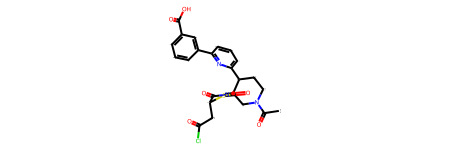

In [123]:
mol

In [142]:
c = mol.GetConformer()

In [144]:
for i in range(c.GetNumAtoms()):
    pos = c.GetAtomPosition(i)
    print(pos.x, pos.y, pos.z)

23.224 -41.728 9.705
24.658 -41.539 9.373
25.559 -42.694 9.631
24.941 -43.966 9.407
25.68 -45.014 8.825
25.16 -46.132 8.622
27.09 -44.8 8.447
23.582 -44.171 9.779
22.635 -43.081 9.433
22.056 -43.206 8.084
22.851 -43.155 6.939
24.084 -43.042 6.758
21.732 -43.291 5.545
20.355 -43.976 6.553
20.681 -43.379 7.853
19.776 -43.057 8.679
20.6 -45.483 6.569
19.344 -46.239 6.462
18.372 -45.807 7.057
19.172 -47.716 5.533
21.262 -40.224 9.494
20.547 -39.207 8.953
21.127 -38.537 7.903
22.394 -38.892 7.421
23.017 -39.933 8.044
22.461 -40.627 9.101
19.233 -38.869 9.476
18.891 -37.631 9.924
17.618 -37.336 10.42
16.666 -38.315 10.463
16.991 -39.579 10.013
18.254 -39.843 9.529
17.334 -35.993 10.882
16.574 -35.85 11.874
17.867 -34.859 10.272
